In [126]:
# SQUARE LATTICE APPROACH 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM, GRU
# from tensorflow.keras.layers import Activation
# import tensorflow as tf
# from tensorflow.keras.layers import SimpleRNN, Dense
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
from itertools import islice

In [2]:
# 50 by 50 grid
N = 50

Generate some initial random grids of spins

In [3]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

lattice_hot = np.random.random_integers(0,1,(N,N))
lattice_hot[lattice_hot==0] =- 1

lattice_cold = np.ones((N,N))

/tmp/ipykernel_840593/822622574.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  lattice_hot = np.random.random_integers(0,1,(N,N))


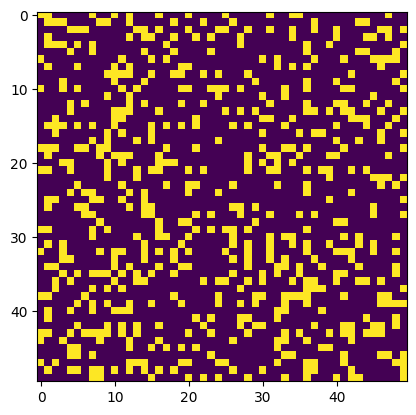

In [4]:
plt.imshow(lattice_n)

Function to get the energy $E/J = -\sum_{<i,j>} \sigma_i\sigma_j$

In [5]:
def bc(i):
    if i > N-1:
        return 0
    if i < 0:
        return N-1
    else:
        return i

In [6]:
def energy_nm(lattice, n, m):
    return -1 * lattice[n,m] * (lattice[bc(n-1), m] + lattice[bc(n+1), m] + lattice[n, bc(m-1)] + lattice[n, bc(m+1)])

def Energy(lattice):
    energy=0
    for j in range(0,N):
        for k in range(0,N):
            energy+=energy_nm(lattice,j,k)
    return energy/2

In [7]:
# def get_energy(lattice):
#     # applies the nearest neighbours summation
#     kern = generate_binary_structure(2, 1) 
#     kern[1][1] = False
#     arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
#     return (arr.sum())/2

In [8]:
Energy(lattice_p)

-1224.0

In [9]:
Energy(np.array([[-1.,  1., -1., -1.,  1.,  1.],
        [-1.,  1., -1., -1.,  1., -1.],
        [-1., -1.,  1.,  1.,  1.,  1.],
        [ 1., -1., -1.,  1., -1., -1.],
        [ 1.,  1.,  1.,  1., -1., -1.],
        [-1., -1., -1.,  1., -1.,  1.]]))

IndexError: index 49 is out of bounds for axis 0 with size 6

In [10]:
# get_energy(lattice_p)

In [11]:
# @numba.njit("Tuple((f8[:], f8[:], boolean[:, :, :]))(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
@numba.jit(nopython=True)
def metropolis(lattice, times, BJ, energy):
    lattice = lattice.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    lattices = np.zeros((times-1,N,N), dtype=np.bool_)

    def bc(i):
        if i > N-1:
            return 0
        if i < 0:
            return N-1
        else:
            return i
        
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        # x = np.random.randint(0,N)
        # y = np.random.randint(0,N)
        # spin_i = lattice[x,y] #initial spin
        # spin_f = spin_i*-1 #proposed spin flip
        
        # # compute change in energy
        # E_i = 0
        # E_f = 0
        # if x>0:
        #     E_i += -spin_i*lattice[x-1,y]
        #     E_f += -spin_f*lattice[x-1,y]
        # if x<N-1:
        #     E_i += -spin_i*lattice[x+1,y]
        #     E_f += -spin_f*lattice[x+1,y]
        # if y>0:
        #     E_i += -spin_i*lattice[x,y-1]
        #     E_f += -spin_f*lattice[x,y-1]
        # if y<N-1:
        #     E_i += -spin_i*lattice[x,y+1]
        #     E_f += -spin_f*lattice[x,y+1]
        
        # # 3 / 4. change state with designated probabilities
        # dE = E_f-E_i

        # if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
        #     lattice[x,y]=spin_f
        #     energy += dE
        # elif dE<=0:
        #     lattice[x,y]=spin_f
        #     energy += dE

        # Lattice_flip=lattice.copy()
        # dE=0
        # for i in range(5):
        j = np.random.randint(0,N)
        k = np.random.randint(0,N)
        
        sum_nn = lattice[bc(j-1), k] + lattice[bc(j+1), k] + lattice[j, bc(k-1)] + lattice[j, bc(k+1)]
        # Lattice_flip[j,k] = -lattice[j,k]
        new_spin=-lattice[j,k]
        # dE =-1*(Lattice_flip[j,k]-lattice[j,k])*sum_nn
        dE =-1*(new_spin-lattice[j,k])*sum_nn
        # lattice=Lattice_flip
        
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            lattice[j,k]=new_spin
            energy += dE
        elif dE<=0:
            lattice[j,k]=new_spin
            energy += dE
            
        net_spins[t] = lattice.sum()
        net_energy[t] = energy
        lattices[t,:,:]=(lattice+1).astype(np.bool_)
            
    return net_spins, net_energy, lattices

In [12]:
spins, energies, _ = metropolis(lattice_n, 10000, 2, Energy(lattice_n))

In [13]:
((lattice_n+1).astype(np.bool_).astype(np.int8)-1/2)*2

array([[ 1.,  1., -1., ...,  1., -1., -1.],
       [-1.,  1.,  1., ..., -1., -1., -1.],
       [-1., -1., -1., ...,  1., -1.,  1.],
       ...,
       [ 1., -1.,  1., ..., -1.,  1.,  1.],
       [-1.,  1., -1., ..., -1., -1.,  1.],
       [-1., -1., -1., ..., -1., -1.,  1.]])

In [14]:
plt.imshow(lattices[-30,:,:])

NameError: name 'lattices' is not defined

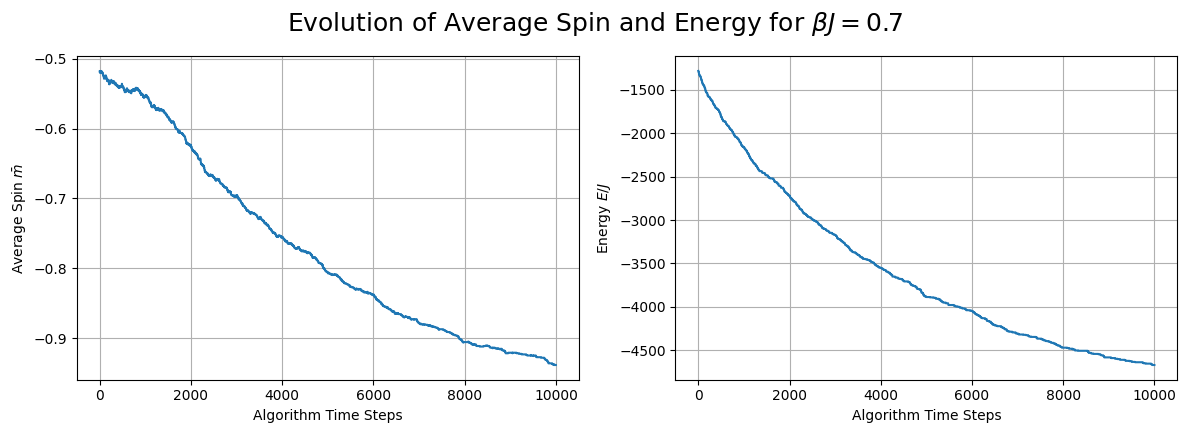

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

We can get $\bar{m}$ and $E/J$ for many different values of $\beta J$. The values will be the average of the last 100000 points on the figure above.

In [16]:
def get_spin_energy(lattice, BJs, Data_len, Max_iteration):
    ms = np.zeros((len(BJs),Data_len))
    E = np.zeros((len(BJs),Data_len))
    Lattices = np.zeros((len(BJs),Data_len,N,N), dtype=np.bool_)
    for i, bj in enumerate(BJs):
        spins, energies, lattices = metropolis(lattice, Max_iteration, bj, Energy(lattice))
        ms[i,:] = spins[-Data_len:]
        E[i,:] = energies[-Data_len:]
        Lattices[i,:,:,:] = lattices[-Data_len:,:,:]
        print(i)
    return ms, E, Lattices

Max_iteration=100001
Data_len=100
# BJs = np.arange(0.1, 2, 0.1)
T= np.arange(0.01,10,0.6)
BJs=1/T
ms_n, E_n, Lattices_n = get_spin_energy(lattice_n, BJs, Data_len, Max_iteration)
ms_p, E_p, Lattices_p = get_spin_energy(lattice_p, BJs, Data_len, Max_iteration)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


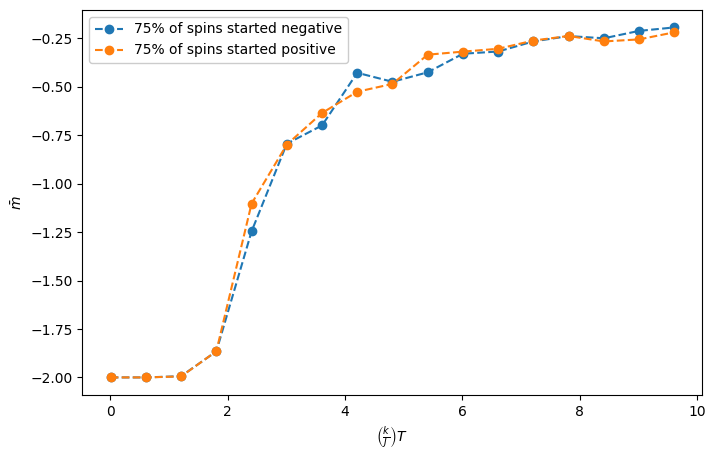

In [23]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, E_n.mean(axis=1)/N**2, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, E_p.mean(axis=1)/N**2, 'o--', label='75% of spins started positive')
# plt.plot(1/BJs, -N*np.tanh(BJs))
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

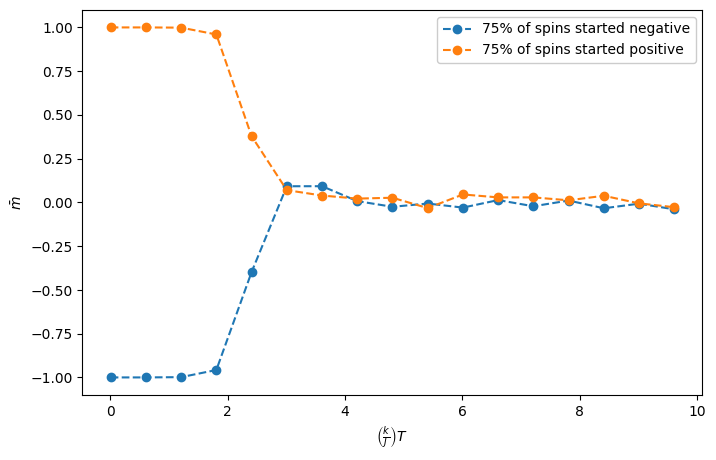

In [21]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n.mean(axis=1)/N**2, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p.mean(axis=1)/N**2, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [49]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies, _ = metropolis(lattice, 100000, bj, get_energy(lattice))
        ms[i] = spins[-10000:].mean()/N**2
        E_means[i] = energies[-10000:].mean()
        E_stds[i] = energies[-10000:].std()
        print(i)
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


Can look at $\bar{m}$ as a function of temperature $T = 1/\beta k = J/(\beta J)k$

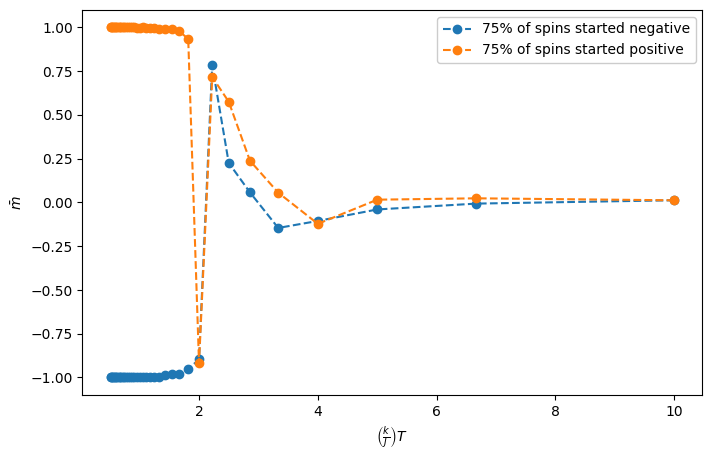

In [48]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

Plot heat capacity as a function of time, using the fact that 

$$C_V = \sigma_E^2 / T^2 $$

$$= (\left<E^2\right>-\left<E\right>^2) \cdot \beta^{2} k^2$$

$$= \left(\left<\left(\frac{E}{J}\right)^2\right>-\left<\frac{E}{J}\right>^2 \right) \cdot (\beta J)^{2} k^2 $$

$$= \sigma_{E/J}^2 \cdot (\beta J)^{2} k^2$$

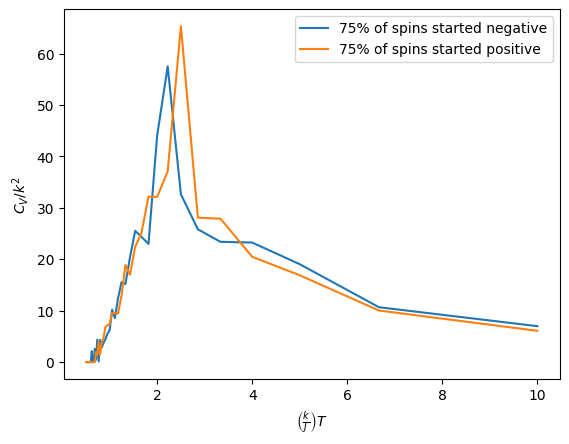

In [72]:
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

In [13]:
class ProductRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output 1 number

    def forward(self, BJ, x):
        x = x.view(-1, 1) # flatten + transpose
        # print(x)
        h0 = torch.zeros(self.rnn.num_layers, self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        out, _ = self.rnn(x, h0)
        print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        print(out.shape)
        out = F.softmax(out, dim=0) # normalizing o/p at each time stamp
        print(out.shape)
        out = torch.prod(out, dim=0) # multiplying all o/ps to get single probablitlity for the entire configuration
        print(out.shape)

        
        # h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # out, _ = self.rnn(x, h0)
        # # print(out.shape)
        # out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # # print(out.shape)
        # out = F.softmax(out, dim=1) # normalizing o/p at each time stamp
        # # print(out.shape)
        # out = torch.prod(out, dim=1) # multiplying all o/ps to get single probablitlity for the entire configuration
        # # print(out.shape)
        return out[0]

# Example usage
sequence_length = 7
input_size = 1 # fixed spin up or down
# batch_size = 1

random_input = torch.rand((sequence_length, input_size))
# random_input = torch.rand((batch_size, sequence_length, input_size))

In [213]:
# Create an instance of the RNN model
model = ProductRNN(input_size, hidden_size=5, num_layers=1)

lattice_cold_tensor = torch.tensor(lattice_cold, dtype=torch.float32)

# Forward pass to get the output
# output = model(random_input)
output = model(lattice_cold_tensor)

print("Input shape:", lattice_cold_tensor.shape)
print("Output shape:", output.shape)

torch.Size([25, 5])
torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([1])
Input shape: torch.Size([5, 5])
Output shape: torch.Size([])


In [208]:
output

tensor(1.0642e-35, grad_fn=<SelectBackward0>)

In [303]:
BJs[-1]

0.10405827263267431

In [ ]:
# class ProductRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=1):
#         super(ProductRNN, self).__init__()
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 1)  # Output 1 number

#     def forward(self, bj, x):
#         x = x.view(x.size(0), -1,1) # flatten + transpose
#         # print(x)
#         # print(x.shape,bj.shape,bj.view(-1,1,1).shape)
#         x=torch.cat((bj.view(-1,1,1),x), dim=1)
#         # print(x.shape)
#         h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
#         out, _ = self.rnn(x, h0)
#         # print(out[:,1:,:].shape)
#         out=out[:,1:,:]
#         out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
#         # out=out.to(torch.float64)
#         # out = F.softmax(out, dim=0) # normalizing o/p at each time stamp
#         # print(sum(out))
#         # out = torch.prod(out, dim=0) # multiplying all o/ps to get single probablitlity for the entire configuration
#         out = F.log_softmax(out, dim=1) # normalizing o/p at each time stamp
#         # print(sum(out))
#         # print(out.shape)
#         out = torch.sum(out, dim=1)
#         # print(out.shape)
#         return out

# q = ProductRNN(input_size, hidden_size=5, num_layers=1)

# N=50
# lattice_cold = np.ones((N,N))
# lattice_cold_tensor = torch.tensor(lattice_cold, dtype=torch.float32)

# output = q(lattice_cold_tensor).double()
# # output = q(random_input)

# print("Input shape:", lattice_cold_tensor.shape)
# print("Output shape:", output.shape)
# print(output)

In [182]:
input_size=1
hidden_size=70
num_layers=2
Log_q = ProductRNN2(input_size, hidden_size, num_layers)

optimizer = optim.Adam(Log_q.parameters(), lr=0.001)


In [183]:
batch_loss=[[] for i in range(len(BJs))]

In [184]:
Loss=[]

In [185]:
num_epochs = 13

In [186]:
# lattice_ = (Lattices[0,:,:].astype(np.int8)-1/2)*2
# lattice = torch.tensor(lattice_, dtype=torch.float32)
# Log_q(lattice)[0]
# 1

0
200
400
Epoch 1/13, Total Loss: 224.82861328125
0
200
400
Epoch 2/13, Total Loss: 216.2944793701172
0
200
400
Epoch 3/13, Total Loss: 215.07211303710938
0
200
400
Epoch 4/13, Total Loss: 214.50180053710938
0
200
400
Epoch 5/13, Total Loss: 213.8841552734375
0
200
400
Epoch 6/13, Total Loss: 213.45663452148438
0
200
400
Epoch 7/13, Total Loss: 212.89633178710938
0
200
400
Epoch 8/13, Total Loss: 212.40252685546875
0
200
400
Epoch 9/13, Total Loss: 211.7438507080078
0
200
400
Epoch 10/13, Total Loss: 211.04733276367188
0
200
400
Epoch 11/13, Total Loss: 210.42098999023438
0
200
400
Epoch 12/13, Total Loss: 209.69517517089844
0
200
400
Epoch 13/13, Total Loss: 208.9643096923828


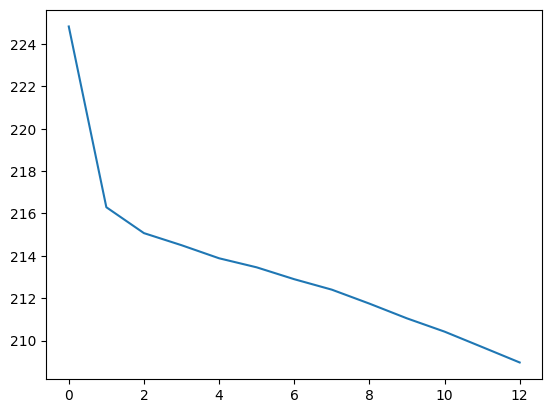

In [187]:
def free_energy(lattice, energy, bj, log_q):
    log__q = log_q(bj,lattice).view(-1)
    # print(log__q)
    # print(energy*bj + log__q)
    # log_q = torch.log(output)
    # print(log__q.shape)
    # print(energy.shape)
    # print((energy*bj).shape)
    
    # log_loss = -(log__q + torch.log(-energy*bj - log__q))

    condition = (energy * bj + log__q) < 0
    # print(bj)
    # print(energy * bj)
    for i in condition:
        if i==False:
            print('---')
    positive_loss = -(log__q + torch.log(-(energy * bj + log__q)))
    negative_loss = log__q + torch.log(energy * bj + log__q)
    log_loss = torch.where(condition, positive_loss, negative_loss)
    
    # log_loss = (energy*bj + log__q)**2
    # log_loss = (energy*bj + log__q)*torch.exp(log__q)
    
    # print('b')
    # print(log_loss,torch.sum(log_loss))
    # print(log_loss.shape)
    return log_loss

# torch.autograd.set_detect_anomaly(False)

# Batch_size = 64

for epoch in range(num_epochs):
    total_loss = 0

    # for i in range(int(len(Lattices)/1000)):
        # #lattice_ = (Lattices[i].astype(np.int8)-1/2)*2
    #     lattice = torch.tensor(lattice_, dtype=torch.float32)
    #     energy = Energies[i]
    #     bj = BJS[i]

    #     optimizer.zero_grad()
    #     # print('a')
    #     # Calculate the objective function and backpropagate
    #     loss = free_energy(lattice, energy, bj, Log_q)
    #     # print('b')
    #     # print(loss)
    #     total_loss += loss#.item()
    #     if (i%200==0):
    #         print(i)
    #     # l

    # num_batches_to_use = 100

    for batch_idx, (lattices_batch, energies_batch, bjs_batch) in enumerate(dataloader):
    # for batch_idx, (lattices_batch, energies_batch, bjs_batch) in itertools.islice(enumerate(dataloader), num_batches_to_use):
        optimizer.zero_grad()
        # Calculate the objective function and backpropagate
        loss = free_energy(lattices_batch, energies_batch, bjs_batch, Log_q)
        total_loss += loss.mean()/N**2
        # print(total_loss)
        # print(energies_batch)
        # l
        
        if (batch_idx % 200 == 0):
            print(batch_idx)
    
        ((loss.mean())/N**2).backward()
        optimizer.step()

        # for jj in range(len(BJs)):
        #     I=torch.nonzero(bjs_batch==BJs[jj]).view(-1)
        #     # print(I)
        #     # print(loss[I].mean())
        #     batch_loss[jj].append(((loss[I].mean())/N**2).item())
        #     # for kk in range(len(bjs_batch)):
        #     #     if bjs_batch[kk]==BJs[jj]:
        #     #         batch_loss[jj].append(((loss)/N**2)[kk].item())
        # mknn
    # total_loss.backward()
    # optimizer.step()
    Loss.append(total_loss.item())
    # Print the total loss for this epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss}')
plt.plot(Loss)

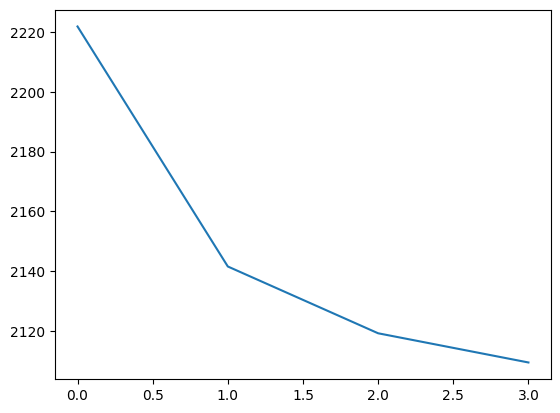

In [273]:
plt.plot(Loss)

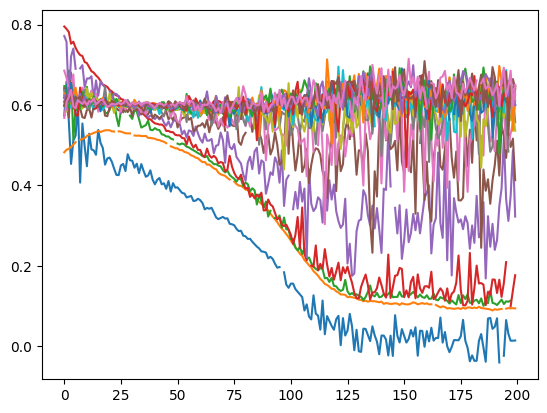

In [410]:
for i in range(len(BJs)):
    plt.plot(np.array(batch_loss[i]))

In [408]:
BJs

array([100.        ,   1.63934426,   0.82644628,   0.55248619,
         0.41493776,   0.33222591,   0.27700831,   0.23752969,
         0.20790021,   0.18484288,   0.16638935,   0.15128593,
         0.13869626,   0.12804097,   0.11890606,   0.11098779,
         0.10405827])

In [66]:
E_n.flatten().shape

(100000,)

In [64]:
BJS_n=np.repeat(BJs,10000)
BJS_p=np.repeat(BJs,10000)

In [65]:
BJS_n.shape

(100000,)

In [33]:
Lattices_n.shape

(10, 1000, 10, 10)

In [37]:
Lattices_n.reshape((100000,50,50)).shape

ValueError: cannot reshape array of size 1000000 into shape (100000,50,50)

In [79]:
E_n

array([[ -526.,  -522.,  -518., ...,  -338.,  -342.,  -346.],
       [-1482., -1482., -1482., ..., -1762., -1766., -1762.],
       [-4346., -4346., -4346., ..., -4250., -4250., -4242.],
       ...,
       [-4982., -4982., -4982., ..., -4982., -4982., -4982.],
       [-4982., -4982., -4982., ..., -4982., -4982., -4982.],
       [-4982., -4982., -4982., ..., -4982., -4982., -4982.]])

In [35]:
Data_len*len(BJs)

10000

In [84]:
np.concatenate((E_n.flatten(),E_p.flatten()),axis=0).shape

(200000,)

In [85]:
np.concatenate((BJS_n,BJS_p),axis=0).shape

(200000,)

In [86]:
np.concatenate((Lattices_n.reshape((100000,50,50)),Lattices_p.reshape((100000,50,50))),axis=0).shape

(200000, 50, 50)

In [137]:
BJS_n=np.repeat(BJs,Data_len)
BJS_p=np.repeat(BJs,Data_len)
BJS=np.concatenate((BJS_n,BJS_p),axis=0)

Energies=np.concatenate((E_n.flatten(),E_p.flatten()),axis=0)

Lattices=np.concatenate((Lattices_n.reshape((Data_len*len(BJs),N,N)),Lattices_p.reshape((Data_len*len(BJs),N,N))),axis=0)

In [138]:
Lattices = torch.tensor([((lattice.astype(np.int8) - 1/2) * 2).astype(np.float32) for lattice in Lattices])

In [139]:
Energies = torch.tensor(Energies, dtype=torch.float32)
BJS = torch.tensor(BJS, dtype=torch.float32)

In [140]:
dataset = TensorDataset(Lattices, Energies, BJS)

In [141]:
Batch_size=64
dataloader = DataLoader(dataset, batch_size=Batch_size, shuffle=True)

/tmp/ipykernel_13487/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0, 0.5, '$S$')

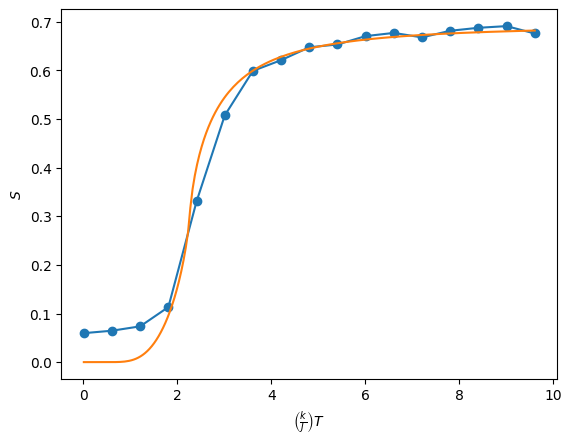

In [188]:
S=np.zeros(len(BJs))
for i in range(len(BJs)):
    with torch.no_grad():
        I=torch.nonzero(BJS==BJs[i]).view(-1)
        bjs_batch=BJS[I]
        lattices_batch=Lattices[I]
        # print(I)
        log__q = Log_q(bjs_batch,lattices_batch).view(-1)
        S[i]=-torch.mean(log__q).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.scatter(1/BJs,S)

T_values = np.linspace(0.01, 1/BJs[-1], 200)
S_values_temp = [Entropy(T) for T in T_values]
plt.plot(T_values, S_values_temp)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

/tmp/ipykernel_13487/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0, 0.5, '$S$')

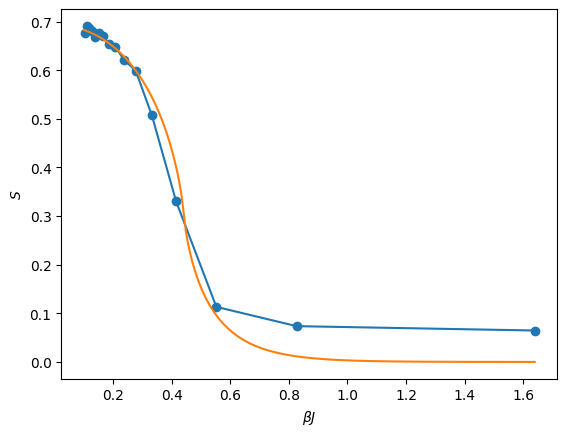

In [189]:
plt.plot(BJs[1:],S[1:])
plt.scatter(BJs[1:],S[1:])
Beta_values = np.linspace(0.1, BJs[1], 200)
S_values_beta = [Entropy(1/Beta) for Beta in Beta_values]
plt.plot(Beta_values, S_values_beta)
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [190]:
S

array([0.05957698, 0.06462596, 0.07360173, 0.11324839, 0.3304765 ,
       0.50733858, 0.59907325, 0.62109767, 0.64760378, 0.65332127,
       0.67059294, 0.67713467, 0.66793876, 0.68154446, 0.68767574,
       0.69111676, 0.67595175])

In [123]:
# Generate all lattice configs for a single BJ

M = 2

# Generate all possible configurations using binary representation
possible_configs = np.array([list(map(int, list(format(i, '0' + str(M**2) + 'b')))) for i in range(2**(M**2))])

# Convert 0s to -1s in the array
possible_configs[possible_configs == 0] = -1

# print(possible_configs)
# Reshape the array to MxM
Lattices = torch.tensor(possible_configs.reshape(-1, M, M))
# Shape: (2**(M**2), M, M)

BJS=torch.ones((2**(M**2)))*0.3
# Lattices
# Print the result
# for config in possible_configs:
#     print(config)

In [143]:
# testing that sum of all lattice configs is equal to 1

class ProductRNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN1, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output 2 numbers: one for each +1, -1

    def forward(self, bj, x):
        x = x.view(x.size(0), -1,1) # flatten + transpose
        # print(((x+1)/2).shape)
        # print(x[:,0:-1,:].shape)
        Zeros=torch.zeros(x.size(0), 1, 1)
        #bj.view(-1,1,1)
        x_0=torch.cat((bj.view(-1,1,1),x[:,0:-1,:]), dim=1)
        # print(x_0.shape)
        # x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.view(-1,1,1).shape)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # print(x)
        out, _ = self.rnn(x_0, h0)
        # print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # print(out.shape)
        out = F.log_softmax(out, dim=2) # normalizing o/p at each time stamp
        extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values.shape)
        sum_result = extracted_values.sum(dim=1)
        # print(sum_result.shape)
        # print(out)
        
        
        # out = F.softmax(out, dim=2) # normalizing o/p at each time stamp
        # print(out)
        # extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values)
        # sum_result = torch.prod(extracted_values,dim=1)
        # print(sum_result.shape)
        return sum_result

    def generate_lattice(self, bj, n_iterations):
        # bj is tensor(0.300) for example
        # Ensure bj is a tensor and has the correct shape
        x=bj.view(-1,1,1)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(bj.device)
        # Initialize the generated lattice configuration
        generated_lattice = np.zeros((x.size(0),n_iterations))

        with torch.no_grad():
            for i in range(n_iterations):
                # print(x.shape)
                out, h0 = self.rnn(x, h0)
                # print(out)
                # print(h0)
                out = self.fc(out)
                out = F.softmax(out, dim=2)
                # print(out.shape)
                # print(out)
                # Sample from the output probabilities
                # print(out[:, -1, :])
                
                array=out[:,-1,:]
                # print(array)
                # array[3]=torch.tensor([0.1,0.9])
                condi=(array[:, 0] > array[:, 1]).float().view(-1,1)
                # print(array,torch.concatenate((condi,1-condi),dim=1))
                # max_values, _ = array.max(dim=1, keepdim=True)
                # print(max_values)
                modified_array = (torch.concatenate((condi,1-condi),dim=1)*9+1)*array
                # modified_array = torch.where(array[:, 0] > array[:, 1], torch.tensor([1, 10]), torch.tensor([10, 1]))
                # print(modified_array)
                sampled_index = torch.multinomial(modified_array, 1)
                
                # sampled_index = torch.multinomial(out[:, -1, :], 1)
                
                # print(sampled_index.shape)
                # print(sampled_index)
                # Map sampled index to -1 or +1
                x = (2 * sampled_index - 1).float()
    
                # Append the sampled value to the generated lattice
                generated_lattice[:,i]=x.view(-1)
                x=x.view(-1,1,1)
    
        return generated_lattice.reshape(-1, int(np.sqrt(n_iterations)), int(np.sqrt(n_iterations)))


In [124]:


input_size=1
hidden_size=6
num_layers=3
Log_q = ProductRNN1(input_size, hidden_size, num_layers)

q=torch.exp(Log_q(BJS,Lattices))
# print(q.shape)
print(q.sum())

# q=Log_q(BJS,Lattices).sum()
# print(q)

# Log_q.generate_lattice(BJS[0:12],M**2)
Log_q.generate_lattice(torch.zeros((12)),M**2)

tensor(1., grad_fn=<SumBackward0>)


array([[[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.]],

       [[ 1., -1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1., -1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1., -1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]]])

In [332]:
N = 10
Batch_size=64

BJS=torch.ones((Batch_size))
BJs = np.arange(0.1, 2, 0.05)
BJs

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
       1.75, 1.8 , 1.85, 1.9 , 1.95])

In [142]:
# testing that sum of all lattice configs is equal to 1

class ProductRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN2, self).__init__()
        self.rnn = nn.RNN(input_size+1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output 2 numbers: one for each +1, -1

    def forward(self, bj, x):
        x = x.view(x.size(0), -1,1) # flatten + transpose
        # print(((x+1)/2).shape)
        # print(x[:,0:-1,:].shape)
        Zeros=torch.zeros(x.size(0), 1, 1)
        #bj.view(-1,1,1)
        # print(x[:,0:-1,:].shape,Zeros.shape)
        x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.repeat(x_0.size(1)).view(-1,x_0.size(1),1).shape)
        x_0=torch.cat((x_0,bj.repeat(x_0.size(1)).view(-1,x_0.size(1),1)),dim=2)
        # print(x_0)
        # print(x_0)
        # x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.view(-1,1,1).shape)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # print(x_0[:,:,0].view(16,9,1).shape)
        # print(x_0[:,:,0].view(-1,4,1))
        out, _ = self.rnn(x_0, h0)
        # print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # print(out.shape)
        out = F.log_softmax(out, dim=2) # normalizing o/p at each time stamp
        extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values.shape)
        sum_result = extracted_values.sum(dim=1)
        # print(sum_result.shape)
        # print(out)
        
        
        # out = F.softmax(out, dim=2) # normalizing o/p at each time stamp
        # print(out)
        # extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values)
        # sum_result = torch.prod(extracted_values,dim=1)
        # print(sum_result.shape)
        return sum_result

    def generate_lattice(self, bj, n_iterations):
        # bj is tensor(0.300) for example
        # Ensure bj is a tensor and has the correct shape
        x=bj.view(-1,1,1)
        Zeros=torch.zeros(x.size(0), 1, 1)
        # print(Zeros.shape,x.shape)
        x=torch.cat((Zeros,x), dim=2)
        # print(x)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(bj.device)
        # Initialize the generated lattice configuration
        generated_lattice = np.zeros((x.size(0),n_iterations))

        with torch.no_grad():
            for i in range(n_iterations):
                # print(x.shape)
                out, h0 = self.rnn(x, h0)
                # print(out)
                # print(h0)
                out = self.fc(out)
                out = F.softmax(out, dim=2)
                # print(out.shape)
                # print(out[:, -1, :].shape)
                # Sample from the output probabilities
                # print(out[:, -1, :])
                sampled_index = torch.multinomial(out[:, -1, :], 1)
                # print(sampled_index.shape)
                # print(sampled_index)
                # Map sampled index to -1 or +1
                x = (2 * sampled_index - 1).float()
    
                # Append the sampled value to the generated lattice
                generated_lattice[:,i]=x.view(-1)
                x=x.view(-1,1,1)
                x=torch.cat((x,bj.view(-1,1,1)), dim=2)
                # print(x)
    
        return generated_lattice.reshape(-1, int(np.sqrt(n_iterations)), int(np.sqrt(n_iterations)))


In [721]:
input_size=1
hidden_size=5
num_layers=1
Log_q = ProductRNN2(input_size, hidden_size, num_layers)

# q=torch.exp(Log_q(BJS,Lattices))
# # print(q.shape)
# print(q.sum())

# q=Log_q(BJS,Lattices).sum()
# print(q)

Log_q.generate_lattice(BJS[0:12],M**2)

array([[[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [-1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [-1., -1.]],

       [[-1.,  1.],
        [ 1.,  1.]],

       [[ 1., -1.],
        [-1.,  1.]],

       [[-1., -1.],
        [ 1.,  1.]],

       [[ 1., -1.],
        [ 1.,  1.]],

       [[-1., -1.],
        [ 1., -1.]],

       [[ 1.,  1.],
        [-1., -1.]],

       [[ 1., -1.],
        [ 1., -1.]]])

In [160]:
input_size=1
hidden_size=70
num_layers=2

models = []
for _ in range(len(BJs)):
    model = ProductRNN1(input_size, hidden_size, num_layers)
    models.append(model)

optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

In [161]:
Loss=[[] for i in range(len(BJs))]

In [162]:
# train
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:')
    for i in range(len(BJs)):#[len(BJs)-1]:#range(1):#len(BJs)):
        I=torch.nonzero(BJS==BJs[i]).view(-1)
        total_loss = 0
        for j in range(0, len(I)-Batch_size, Batch_size):
            optimizers[i].zero_grad()
            I_batch=I[j:min(j+Batch_size,len(I))]
            BJs_batch=BJS[I_batch]
            Lattice_batch=Lattices[I_batch]
            Energy_batch=Energies[I_batch]

            # print(torch.zeros((Batch_size)).shape,Lattice_batch.shape)
            Log_q_batch=models[i](torch.zeros((Lattice_batch.size(0))),Lattice_batch).view(-1)
            # print(Log_q_batch.shape, Energy_batch.shape, BJs_batch.shape, BJs_batch.view(-1,1).shape)
            # print(Energy_batch)
            # loss_batch=(Energy_batch*BJs_batch + Log_q_batch)**2
            # loss_batch=-(Energy_batch*BJs_batch + Log_q_batch)
            # loss_batch=-Log_q_batch
            # loss_batch=(Energy_batch*BJs_batch + Log_q_batch)
            # loss_batch=torch.abs(Energy_batch*BJs_batch + Log_q_batch)
            # print(Log_q_batch)
            # print(Energy_batch)
            # loss_batch=-(Log_q_batch + torch.log(-Energy_batch*BJs_batch - Log_q_batch))
            # print(loss_batch.shape)
            condition=(Energy_batch*BJs_batch + Log_q_batch)<0
            for o in condition:
                if o==False:
                    print('---')
            positive_loss=-(Log_q_batch + torch.log(-(Energy_batch*BJs_batch + Log_q_batch)))
            negative_loss=(Log_q_batch + torch.log((Energy_batch*BJs_batch + Log_q_batch)))
            loss_batch = torch.where(condition, positive_loss, negative_loss)
            
            total_loss_batch=loss_batch.mean()/N**2
            total_loss_batch.backward()
            optimizers[i].step()
            total_loss += loss_batch.mean()/N**2
        Loss[i].append(total_loss.item())
        # print(Energy_batch)
        # kmds
        print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss}')

Epoch 1/10:
Epoch 1/10, Total Loss: 16.76565170288086
Epoch 1/10, Total Loss: 27.6668758392334
Epoch 1/10, Total Loss: 17.67044448852539
Epoch 1/10, Total Loss: 27.85396957397461
Epoch 1/10, Total Loss: 9.15013313293457
Epoch 1/10, Total Loss: 17.420896530151367
Epoch 1/10, Total Loss: 17.087800979614258
Epoch 1/10, Total Loss: 18.301607131958008
Epoch 1/10, Total Loss: 18.38151741027832
Epoch 1/10, Total Loss: 18.38259506225586
Epoch 1/10, Total Loss: 18.476051330566406
Epoch 1/10, Total Loss: 18.670103073120117
Epoch 1/10, Total Loss: 18.5498104095459
Epoch 1/10, Total Loss: 18.497211456298828
Epoch 1/10, Total Loss: 18.740625381469727
Epoch 1/10, Total Loss: 18.735679626464844
Epoch 1/10, Total Loss: 18.615943908691406
Epoch 2/10:
Epoch 2/10, Total Loss: -4.553622245788574
Epoch 2/10, Total Loss: 1.0052316188812256
Epoch 2/10, Total Loss: -0.8207887411117554
Epoch 2/10, Total Loss: 5.219629287719727
Epoch 2/10, Total Loss: 7.662231922149658
Epoch 2/10, Total Loss: 15.622919082641602

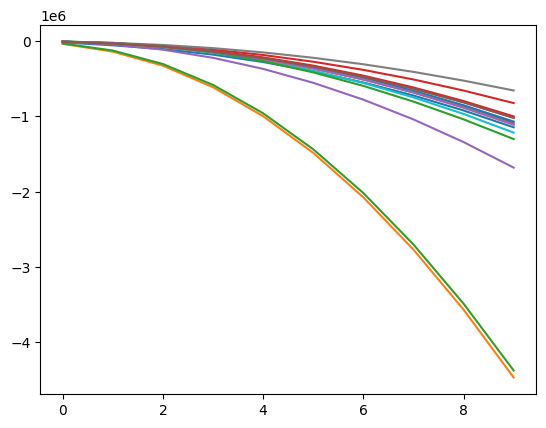

In [120]:
for i in range(1,len(BJs)):
    plt.plot(np.array(Loss[i]))

/tmp/ipykernel_13487/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0, 0.5, '$S$')

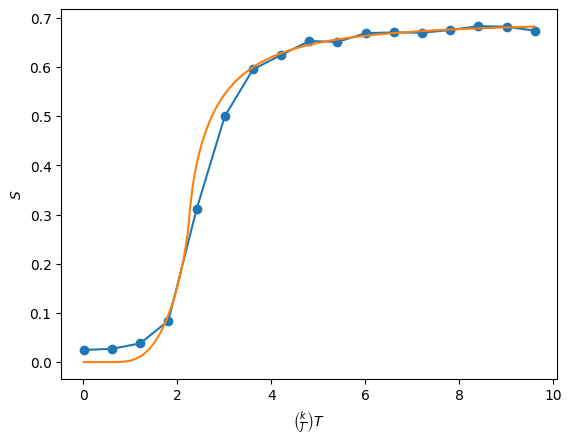

In [166]:
S=np.zeros(len(BJs))
for i in range(len(BJs)):
    with torch.no_grad():
        I=torch.nonzero(BJS==BJs[i]).view(-1)
        bjs_batch=BJS[I]
        lattices_batch=Lattices[I]
        # print(I)
        # print(lattices_batch.size(0),torch.zeros(lattices_batch.size(0)).shape)
        # ds
        Log_q_batch=models[i](torch.zeros(lattices_batch.size(0)),lattices_batch).view(-1)
        S[i]=-torch.mean(Log_q_batch).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.scatter(1/BJs,S)
T_values = np.linspace(0.01, 1/BJs[-1], 200)
S_values_temp = [Entropy(T) for T in T_values]
plt.plot(T_values, S_values_temp)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

/tmp/ipykernel_13487/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0, 0.5, '$S$')

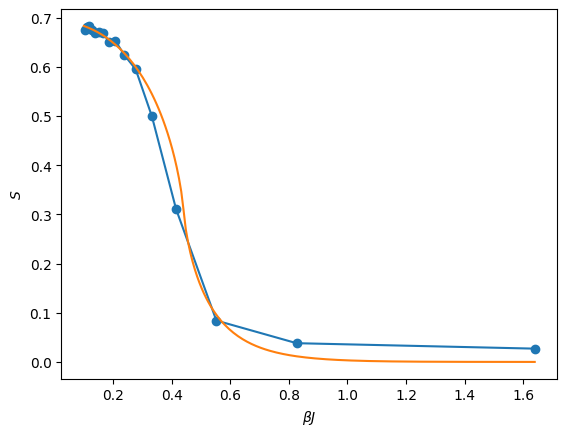

In [165]:
plt.plot(BJs[1:],S[1:])
plt.scatter(BJs[1:],S[1:])
Beta_values = np.linspace(0.1, BJs[1], 200)
S_values_beta = [Entropy(1/Beta) for Beta in Beta_values]
plt.plot(Beta_values, S_values_beta)
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [167]:
S

array([0.02475624, 0.02703977, 0.03809939, 0.08411869, 0.31067313,
       0.4995966 , 0.59489748, 0.62432167, 0.65263621, 0.65096601,
       0.66859706, 0.67022551, 0.66959503, 0.67506817, 0.68298981,
       0.68179067, 0.67371432])

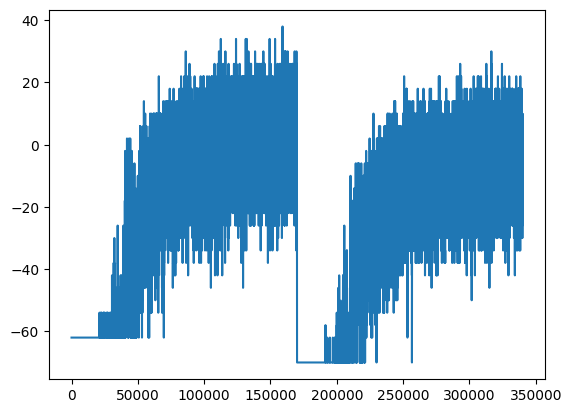

In [175]:
plt.plot(Energies)

In [338]:
T

array([0.01, 0.61, 1.21, 1.81, 2.41, 3.01, 3.61, 4.21, 4.81, 5.41, 6.01,
       6.61, 7.21, 7.81, 8.41, 9.01, 9.61])

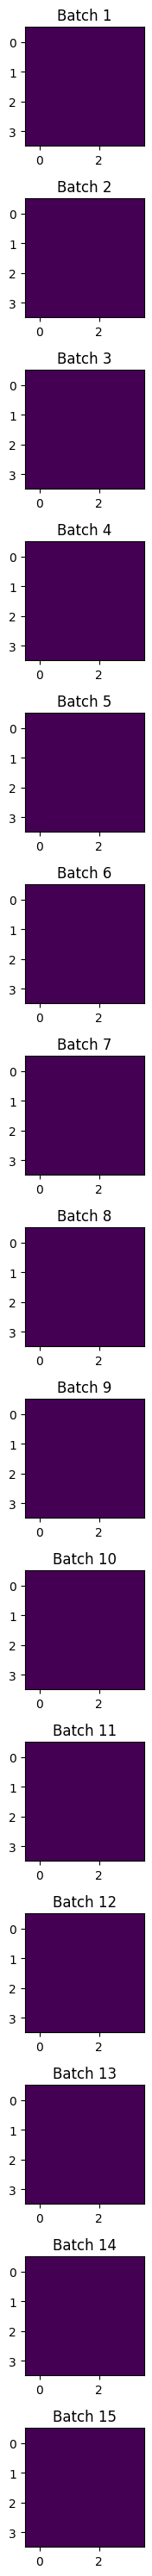

In [114]:
with torch.no_grad():
    J=0
    I=torch.nonzero(BJS==BJs[J]).view(-1) # CHANGE ME
    I=I[-15:]
    bjs_batch=BJS[I]
    lattices_batch=Lattices[I]
    # print(I)
    # print(bjs_batch)
    Log_q=models[J]
    Lattice_gen = Log_q.generate_lattice(bjs_batch,N**2)
    # plt.imshow(Lattice_gen[0])

    bbatch_size, rows, cols = Lattice_gen.shape
    fig, axs = plt.subplots(nrows=bbatch_size, ncols=1, figsize=(6, 2 * bbatch_size))

    for i in range(bbatch_size):
        axs[i].imshow(Lattice_gen[i])
        # axs[i].imshow(lattices_batch[i])
        axs[i].set_title(f"Batch {i+1}")
        # axs[i].grid(True, which='both', linestyle='--', linewidth=0.5, color='black')

    plt.tight_layout()
    # plt.show()

In [125]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.misc import derivative
# from findiff import FinDiff, coefficients, Coefficient
# import numdifftools as nda

def Z(k):
    def integrand(w, k):
        return np.arccosh(np.cosh(2 * k) * np.cosh(np.log(np.cosh(k)/np.sinh(k))) - np.cos(w))

    integral, _ = quad(integrand, 0, np.pi, args=(k,))  # Numerical Integration
    return -0.5 * np.log(2 * np.sinh(2 * k)) - integral / (2 * np.pi)
def Entropy(T):
    k = 1 / T
    z=Z(k)
    # z=[]
    # for k_ in k:
    #     z.append(Z(k_))

    # z=np.array(z)
    # dz_dk = (Z(k + 0.001) - Z(k - 0.001)) / 0.002  # Numerical Differentiation
    # d_dx = FinDiff(0, 1e-6, 1)
    # dz_dk = d_dx(z)
    dz_dk = derivative(Z, k, dx=1e-6)
    # Dz_Dk = nda.Derivative(Z)
    # dz_dk =Dz_Dk(k)
    return -(z - k * dz_dk)


T_values = np.linspace(0.01, 7, 200)
# S_values_temp=Entropy(T_values)
S_values_temp = [Entropy(T) for T in T_values]

Beta_values = np.linspace(0.1, 2, 200)
S_values_beta = [Entropy(1/Beta) for Beta in Beta_values]

/tmp/ipykernel_13487/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)
